### Abstract

In this notebook, I would try to implement the random-forest classification algorithm. 

The implementation is inspired by a post from [machinelearningmastery.com](https://machinelearningmastery.com/implement-random-forest-scratch-python/), and reconstructed with a few improvements: 

- Use the efficient libraries such as *Pandas* and *Numpy*, instead of basic *list* and *dictionary*.


- Visualize the resulting decision tree, with the Pydot framework.


In [213]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13,6
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 100

### Dataset

Here we use [a dataset from UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks%29) for testing.

In [4]:
!ls sonar*

sonar.all-data	sonar.mines  sonar.names  sonar.rocks


In [8]:
! head sonar.all-data -n 3

0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.

In [28]:
df_data = pd.read_csv('./sonar.all-data', header=None)

print('Num of rows:', len(df_data))
print('Num of columns:', len(df_data.columns))

Num of rows: 208
Num of columns: 61


### Decision Tree

In [296]:
def gini_index(df_groups, target_feature_index):
    """
    """
    total_samples = sum([len(group) for group in df_groups])
    gini_value = 0.0
    
    for group in df_groups:
        group_size = float(len(group))
        if group_size == 0:
            continue
        
        class_count = group[target_feature_index].value_counts()
        group_gini = sum([(count/group_size) **2 for count in class_count])
        
        # weight the group gini value by its relative size
        gini_value += (1 - group_gini) * (group_size / total_samples)
    
    return gini_value


def tree_node_split(df, column_index, split_value):
    """
        Split the dataframe based on the values within a specified column,
          the ones (with rows) < 'split_value' on the left subnode,
          and the one >= 'split_value' on the right subnode.  
        
        df: DataFrame
        
        return:  two dataframes
    """
    left_node = []
    right_node = []
    
    for index in range(len(df)):
        row = df.iloc[index]
        if row[column_index] < split_value:
            left_node.append(row)
        else:
            right_node.append(row)
    
    split_groups = [left_node, right_node]
    split_groups = [pd.concat(group, axis=1).T if len(group) else pd.DataFrame() for group in split_groups]
    return split_groups
    #return (pd.concat(left_node, axis=1).T, pd.concat(right_node, axis=1).T)


def get_best_split(df, n_split_features, target_feature_index):
    """ subsample the features,
        enumerate each possible value on each feature to find the best split."""
    import random
    import sys
    feature_indice = list(set(range(len(df.columns))) - set([target_feature_index]))
    sample_features = random.sample(feature_indice, n_split_features)

    b_feature_index = None
    b_feature_value = None
    b_gini_index = sys.maxsize
    b_split_groups = None
    # split over each feature, on each of the unique feature values
    for feature_index in sample_features:
        split_values = df[feature_index].unique()
        
        for feature_value in split_values:
            split_groups = tree_node_split(df, feature_index, feature_value)
            gini_value = gini_index(split_groups, target_feature_index)

            if gini_value < b_gini_index:
                b_gini_index = gini_value
                b_feature_index = feature_index
                b_feature_value = feature_value
                b_split_groups = split_groups
    
    return {"split_feature": int(b_feature_index),
            "split_value": b_feature_value,
            "gini_index": b_gini_index,
            "split_groups": b_split_groups,
            "left_node_size": len(b_split_groups[0]),
            'right_node_size': len(b_split_groups[1])}


def make_leaf_node(group, target_feature_index):
    if len(group) == 0:
        return None
    
    value_counts = group[target_feature_index].value_counts()
    # choose the majority class as the label of the node
    leaf_label = value_counts.sort_values(ascending=False).index[0]
    
    return leaf_label


def create_node(node, n_split_features,
                target_feature_index, depth,
                max_tree_depth = 20, min_node_size = 2):
    """
        recursively split the node, with certain stopping conditions,
         e.g. max_tree_depth, min_node_size etc.
    """
    left_split, right_split = node['split_groups']
    del node['split_groups']
        
    # check for no split, either of the groups is empty
    if len(left_split) == 0 or len(right_split) == 0:
        node['left'] = node['right'] = make_leaf_node(
            pd.concat([left_split, right_split], axis=1),
            target_feature_index)
    
    # check if we reach the maximum depth, then stop splitting
    if depth >= max_tree_depth:
        node['left'] = make_leaf_node(left_split, target_feature_index)
        node['right'] = make_leaf_node(right_split, target_feature_index)
        return
    
    # otherwise, recursively split the left and right node
    if len(left_split) <= min_node_size:
        node['left'] = make_leaf_node(left_split, target_feature_index)
    else:
        node['left'] = get_best_split(left_split, n_split_features, target_feature_index)
        create_node(node['left'],  n_split_features,
                    target_feature_index, depth + 1,
                    max_tree_depth, min_node_size)
    
    if len(right_split) <= min_node_size:
        node['right'] = make_leaf_node(right_split, target_feature_index)
    else:
        node['right'] = get_best_split(right_split, n_split_features, target_feature_index)
        create_node(node['right'],  n_split_features,
                    target_feature_index, depth + 1,
                    max_tree_depth, min_node_size)

        
def build_decision_tree(df, n_split_features, target_feature_index,
                        max_tree_depth = 10, min_node_size = 2):
    root_node = get_best_split(df, n_split_features, target_feature_index)
    
    create_node(root_node, n_split_features, target_feature_index, 1,
                max_tree_depth, min_node_size)
    return root_node

In [351]:
def predict_one(tree_node, row):
    """ Apply the decision tree on a single record
    """
    if row[tree_node['split_feature']] < tree_node['split_value']:
        if isinstance(tree_node['left'], dict):
            return predict(tree_node['left'], row)
        else:
            # return the label on the leaf node
            return tree_node['left']
    else:
        # check the right sub-tree
        if isinstance(tree_node['right'], dict):
            return predict(tree_node['right'], row)
        else:
            return tree_node['right']


def predict_batch(tree, df_data):
    predicted = [predict_one(tree, df_data.iloc[i]) \
                 for i in range(len(df_data))] 
    return predicted


def get_accuracy(actual, predicted):
    correct_count = sum(actual == predicted)
    return float(correct_count) * 100 / len(actual)

In [352]:
predict_one(tree, df_data.iloc[10])

'R'

In [353]:
get_accuracy(df_data[60], predict_batch(tree, df_data))

80.76923076923077

#### Plot Decision Tree

In [325]:
import pydot

# A global variable to generate a unique ID for each node
NODE_COUNT = 0

def gen_node_id():
    global NODE_COUNT
    NODE_COUNT += 1
    return NODE_COUNT


def subtree_to_node(subtree, graph):
    """
        Convert the decision-tree to the representation of node in Pydot
    """
    subroot = pydot.Node(gen_node_id(), 
        label = "gini_index {:.4f} \n split_feature {} \n split_value {} \n left[{}], right[{}]".format(
                             subtree['gini_index'],
                             subtree['split_feature'],
                             subtree['split_value'],
                             subtree['left_node_size'],
                             subtree['right_node_size']))
    graph.add_node(subroot)
    
    if subtree['left']:
        if isinstance(subtree['left'], dict):
            left_node = subtree_to_node(subtree['left'], graph)
        else:
            # leaf node
            left_node = pydot.Node(gen_node_id(),
                    label = "label {}".format(subtree['left']))
            
        graph.add_node(left_node)
        graph.add_edge(pydot.Edge(subroot, left_node))
    
    if subtree['right']:
        if isinstance(subtree['right'], dict):
            right_node = subtree_to_node(subtree['right'], graph)
        else:
            # leaf node
            right_node = pydot.Node(gen_node_id(),
                label = "label {}".format(subtree['right']))
        
        graph.add_node(right_node)
        graph.add_edge(pydot.Edge(subroot, right_node))

    return subroot


def tree_to_graph(tree):
    """ generate a image from the pydot graph """
    graph = pydot.Dot(graph_type='digraph')
    
    root = subtree_to_node(tree, graph)
    
    return graph


from IPython.display import Image, display

def show_graph(graph):
    plt = Image(graph.create_png())
    display(plt)
    

def plot_tree(tree):
    graph = tree_to_graph(tree)
    show_graph(graph)


In [297]:
%%time

tree = build_decision_tree(df_data,
                           n_split_features = 2,
                           target_feature_index = 60,
                           max_tree_depth = 4,
                           min_node_size = 3)

CPU times: user 33.3 s, sys: 4 ms, total: 33.3 s
Wall time: 33.3 s


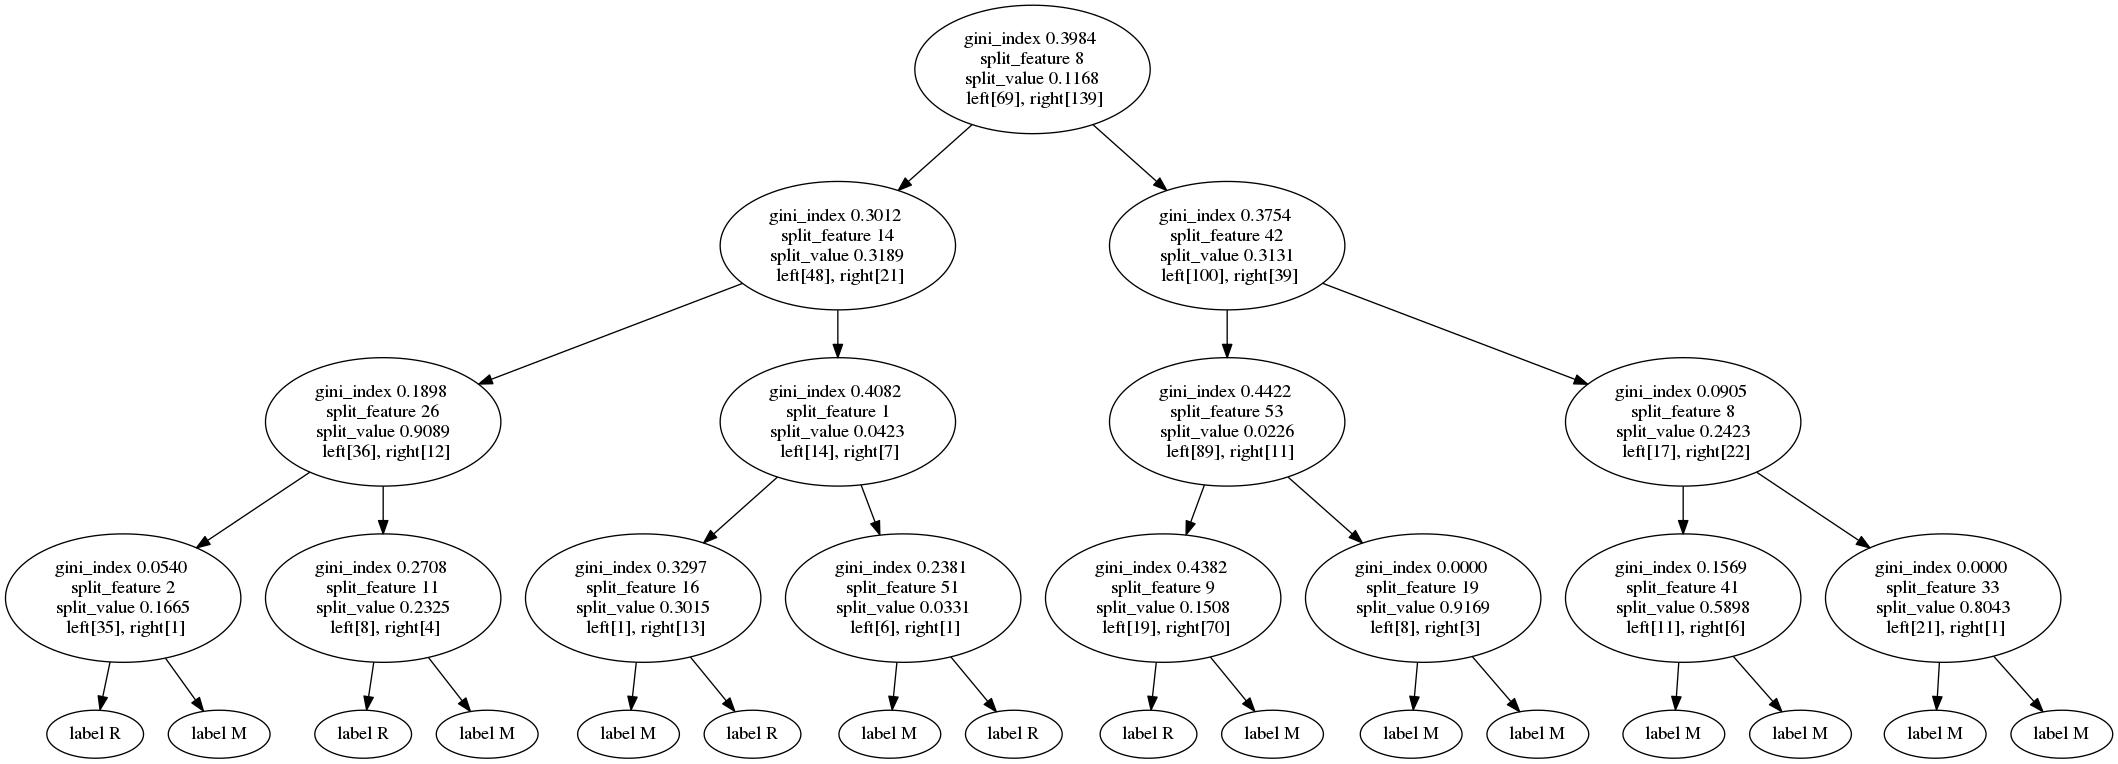

In [283]:
graph = tree_to_graph(tree)
show_graph(graph)

In [288]:
#tree

### Random Forest

Build a list of *decision tree* and do the **emsemble** on the results

In [354]:
import random
    
def bagging_predict(trees, row):
    """ Gather the results given by a list of trees, 
        take the majority one as the response
    """
    predictions = pd.Series([predict_one(tree, row) for tree in trees])
    value_counts = predictions.value_counts().sort_values(ascending=False)
    return value_counts.index[0]


def subsample(df, ratio):
    sample_num = int(len(df) * ratio)
    sample_row_indice = random.sample(range(len(df)), sample_num)
    return df.iloc[sample_row_indice]


class RandomForest:
    def __init__(self, n_trees, n_split_features,
                 sample_ratio = 1.0, # by default, use all training data
                 max_tree_depth = 10, min_node_size = 2,
                 random_seed = 7):
        
        self.n_trees = n_trees
        self.n_split_features = n_split_features
        self.sample_ratio = sample_ratio
        # the split stopping conditions
        self.max_tree_depth = max_tree_depth
        self.min_node_size = min_node_size
        # the list of decision trees to add
        self.trees = []
        random.seed(random_seed)


    def train(self, train_data, target_feature_index):
        
        for i in range(self.n_trees):
            samples = subsample(train_data, self.sample_ratio)
            
            tree = build_decision_tree(samples,
                       n_split_features = self.n_split_features,
                       target_feature_index = target_feature_index,
                       max_tree_depth = self.max_tree_depth,
                       min_node_size = self.min_node_size)
            
            print('build tree #{}'.format(i))
            
            self.trees.append(tree)
    
    
    def predict(self, test_data):
        
        predictions = [bagging_predict(self.trees, test_data.iloc[i]) \
                       for i in range(len(test_data))]
        
        return predictions

In [337]:
rf_model = RandomForest(n_trees=3, n_split_features=3,
                        max_tree_depth=4, min_node_size=2)

In [338]:
%%time

target_feature_index=60

rf_model.train(df_data, target_feature_index=target_feature_index)

build tree #0
build tree #1
build tree #2
CPU times: user 2min 3s, sys: 28 ms, total: 2min 3s
Wall time: 2min 3s


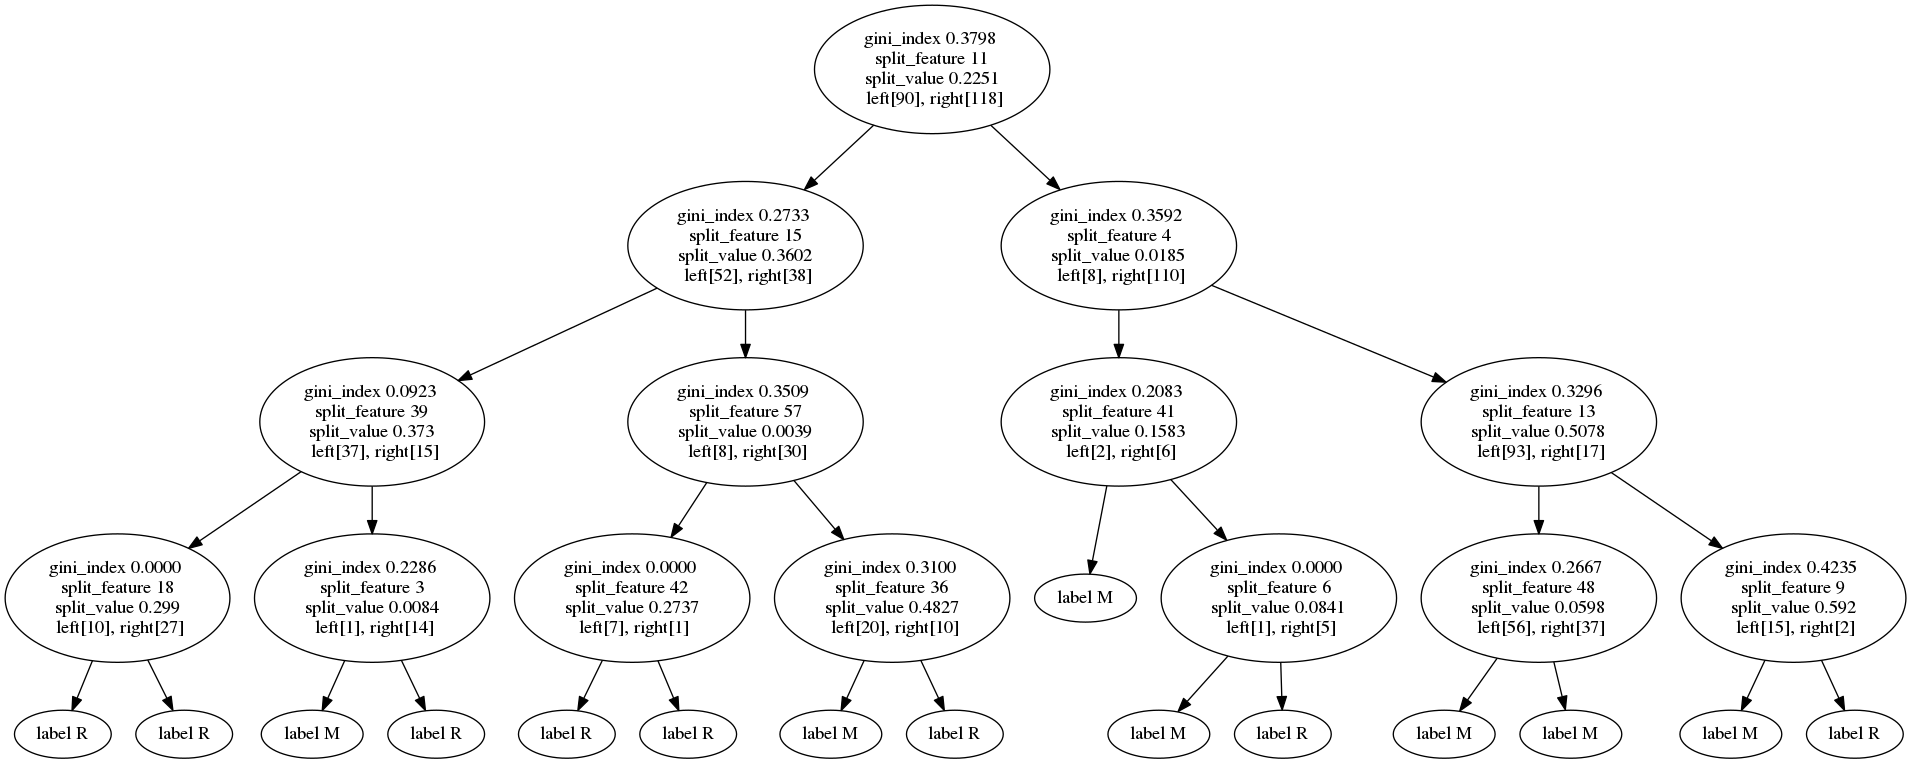

In [340]:
plot_tree(rf_model.trees[0])

In [361]:
target_feature_index = 60

trees_predictions = rf_model.predict(df_data)

accuracy = get_accuracy(df_data[target_feature_index], trees_predictions)
print('accuracy of ensemble trees: {}'.format(accuracy))


accuracy of ensemble trees: 90.38461538461539


In [360]:
print('accuracy of each decision-tree, without ensemble')

for i in range(len(rf_model.trees)):
    single_tree_prediction = predict_batch(rf_model.trees[i], df_data)
    accuracy = get_accuracy(df_data[target_feature_index], single_tree_prediction)
    print('tree #{} accuracy:{}'.format(i, accuracy))

accuracy of each decision-tree, without ensemble
tree #0 accuracy:85.09615384615384
tree #1 accuracy:86.0576923076923
tree #2 accuracy:81.73076923076923


### Examples on How to Use Pydot

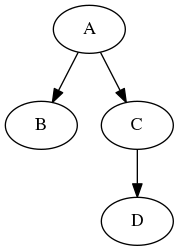

In [226]:
import pydot

graph = pydot.Dot(graph_type='digraph')

node_A = pydot.Node("A")
node_B = pydot.Node("B")
node_C = pydot.Node("C")
node_D = pydot.Node("D")

graph.add_node(node_A)
graph.add_node(node_B)
graph.add_node(node_C)
graph.add_node(node_D)

graph.add_edge(pydot.Edge(node_A, node_B))
graph.add_edge(pydot.Edge(node_A, node_C))
graph.add_edge(pydot.Edge(node_C, node_D))

show_graph(graph)

In [163]:
df_data[60].value_counts().sort_values(ascending=False).index[0]

'M'

In [167]:
make_leaf_node(left_node, target_feature_index=60)

'R'

In [149]:
ret = get_best_split(df_data, 3, target_feature_index=60)

In [103]:
median = df_data[0].median()
per_75 = 0.0355
per_25 = 0.0135

group_split = tree_node_split(df_data, column_index=0, split_value=per_25)

left_node, right_node = group_split

print('split with median: {}, length: {}'.format(median, len(left_node)))

split with median: 0.0228, length: 53


In [98]:
left_node.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.02,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.018,0.0084,0.009,0.0032,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.228,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.018,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.01,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.015,0.0085,0.0073,0.005,0.0044,0.004,0.0117,R
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.099,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R
6,0.0317,0.0956,0.1321,0.1408,0.1674,0.171,0.0731,0.1401,0.2083,0.3513,...,0.0201,0.0248,0.0131,0.007,0.0138,0.0092,0.0143,0.0036,0.0103,R


In [104]:
gini_index(group_split, target_feature_index=60)

0.48102907439486875